In [1]:
import numpy as np

In [2]:
# text processing libraries
import re
import string

# LSTM  
from numpy import array
import matplotlib.pyplot as plt
from pandas import read_csv
import math

import pandas as pd

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 200

num_lstm = np.random.randint(175, 275)
num_dense = np.random.randint(100, 150)
rate_drop_lstm = 0.15 + np.random.rand() * 0.25
rate_drop_dense = 0.15 + np.random.rand() * 0.25
act = 'relu'

In [3]:
from google.colab import files
data_to_load = files.upload()

Saving Train_TP2_Datos_2020-2C.csv to Train_TP2_Datos_2020-2C.csv
Saving Test_TP2_Datos_2020-2C.csv to Test_TP2_Datos_2020-2C.csv


In [58]:
import io
test_df = pd.read_csv(io.BytesIO(data_to_load['Test_TP2_Datos_2020-2C.csv']))
train_df = pd.read_csv(io.BytesIO(data_to_load['Train_TP2_Datos_2020-2C.csv']))

In [59]:
train_df.head()

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Quote_Type,Delivery_Terms,Opportunity_Created_Date,Brand,Product_Type,Size,Product_Category_B,Price,Currency,Last_Activity,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,Product_Family,Product_Name,ASP_Currency,ASP,ASP_(converted)_Currency,ASP_(converted),Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Month,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A
0,27761,EMEA,None,1,1,1,1,0,Bureaucratic_Code_4,6/16/2015,None,Netherlands,Account_Name_619,Opportunity_Name_12598,0,None,Person_Name_51,Person_Name_18,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_2,12/7/2015,None,None,None,None,None,None,NaT,1/30/2016,6/13/2016,Person_Name_18,Product_Family_77,Product_Name_99,EUR,0.52,USD,0.58817,5/1/2016,6/30/2016,2016 - 5,Q2,2016,NaT,10,EUR,5272800.0,EUR,5272800.0,Closed Lost,Prod_Category_A_None
1,27760,EMEA,None,0,0,0,0,0,Bureaucratic_Code_4,6/16/2015,None,Netherlands,Account_Name_619,Opportunity_Name_12600,1,39,Person_Name_51,Person_Name_20,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_2,12/7/2015,None,None,None,None,None,None,NaT,1/20/2016,1/15/2016,Person_Name_20,Product_Family_77,Product_Name_100,EUR,0.53,USD,0.59948,1/18/2016,1/20/2016,2016 - 1,Q1,2016,NaT,0,EUR,48230.0,EUR,48230.0,Closed Won,Prod_Category_A_None
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,4/21/2015,Source_7,United States,Account_Name_1794,Opportunity_Name_469,2,760,Person_Name_64,Person_Name_8,Account_Type_5,Opportunity_Type_1,Non Binding,Delivery_Terms_4,12/8/2015,None,None,None,None,None,None,NaT,9/30/2016,9/29/2016,Person_Name_8,Product_Family_81,Product_Name_91,USD,0.48,USD,0.48000,1/25/2016,1/25/2016,2016 - 1,Q1,2016,NaT,0,USD,83865.6,USD,83865.6,Closed Won,Prod_Category_A_None
3,16808,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,Source_11,United States,Account_Name_1201,Opportunity_Name_415,3,None,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Non Binding,Delivery_Terms_1,12/8/2015,Other,Product_Type_0,Size_4,Product_Category_B_16,0.42,USD,NaT,NaT,3/27/2018,Person_Name_8,Product_Family_209,Product_Name_432,USD,0.53,USD,0.53000,2/1/2018,3/31/2018,2018 - 2,Q1,2018,NaT,14,USD,7421881.5,USD,7421881.5,Closed Lost,Prod_Category_A_None
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,Source_11,United States,Account_Name_1201,Opportunity_Name_851,4,None,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Non Binding,Delivery_Terms_1,12/8/2015,Other,Product_Type_0,Size_4,Product_Category_B_16,0.42,USD,NaT,6/2/2017,3/27/2018,Person_Name_8,Product_Family_209,Product_Name_432,USD,0.53,USD,0.53000,2/1/2018,2/28/2018,2018 - 2,Q1,2018,NaT,25,USD,13357192.5,USD,13357192.5,Closed Lost,Prod_Category_A_None


In [60]:
test_df.head()

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Quote_Type,Delivery_Terms,Opportunity_Created_Date,Brand,Product_Type,Size,Product_Category_B,Price,Currency,Last_Activity,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,Product_Family,Product_Name,ASP_Currency,ASP,ASP_(converted)_Currency,ASP_(converted),Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Month,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Prod_Category_A
0,6140,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,10689,6436,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_8,Non Binding,Delivery_Terms_2,4/12/2019,None,None,None,None,None,None,NaT,4/30/2019,4/12/2019,Person_Name_13,Product_Family_171,Product_Name_332,EUR,0.325,USD,0.36761,5/1/2019,5/31/2019,2019 - 5,Q2,2019,NaT,0,EUR,162240.0,EUR,367419.0,Prod_Category_A_None
1,6146,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,10689,6436,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_8,Non Binding,Delivery_Terms_2,4/12/2019,None,None,None,None,None,None,NaT,4/30/2019,4/12/2019,Person_Name_13,Product_Family_167,Product_Name_315,EUR,0.320,USD,0.36195,5/1/2019,5/31/2019,2019 - 5,Q2,2019,NaT,0,EUR,78624.0,EUR,367419.0,Prod_Category_A_None
2,6151,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,10689,6436,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_8,Non Binding,Delivery_Terms_2,4/12/2019,None,None,None,None,None,None,NaT,4/30/2019,4/12/2019,Person_Name_13,Product_Family_140,Product_Name_241,EUR,0.275,USD,0.31105,5/1/2019,5/31/2019,2019 - 5,Q2,2019,NaT,0,EUR,126555.0,EUR,367419.0,Prod_Category_A_None
3,6118,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,10690,6504,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_8,Non Binding,Delivery_Terms_2,4/12/2019,None,None,None,None,None,None,NaT,4/30/2019,4/25/2019,Person_Name_13,Product_Family_171,Product_Name_328,EUR,0.325,USD,0.36761,6/1/2019,6/28/2019,2019 - 6,Q2,2019,NaT,1,EUR,243360.0,EUR,757783.5,Prod_Category_A_None
4,6124,EMEA,Germany,1,1,1,1,0,Bureaucratic_Code_4,7/5/2017,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,10690,6504,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_8,Non Binding,Delivery_Terms_2,4/12/2019,None,None,None,None,None,None,NaT,4/30/2019,4/25/2019,Person_Name_13,Product_Family_167,Product_Name_315,EUR,0.320,USD,0.36195,6/1/2019,6/29/2019,2019 - 6,Q2,2019,NaT,0,EUR,157248.0,EUR,757783.5,Prod_Category_A_None


In [61]:
#Y convierto las victorias en 1 y derrotas en 0
train_df = train_df[(train_df.Stage == 'Closed Won') | (train_df.Stage == 'Closed Lost')]
train_df['Stage'] = train_df['Stage'].transform(func=lambda x : 1 if x=='Closed Won' else 0)


In [62]:
#Completo datos faltantes con Total Amount
train_df['Total_Taxable_Amount'].loc[train_df.Total_Taxable_Amount==0.00] = train_df.loc[train_df.Total_Taxable_Amount==0.00]\
                                            .groupby(['Opportunity_ID'])['Total_Amount'].transform('sum')

#Convierto a una misma moneda (a dólares) con la información que ya viene en ASP, ASP_Currency y ASP_(converted)
toEUR = train_df[train_df.ASP_Currency=='EUR'].head(1)[['ASP_(converted)']].iloc[0,0]/train_df[train_df.ASP_Currency=='EUR']\
        .head(1)[['ASP']].iloc[0,0]
toAUD = train_df[train_df.ASP_Currency=='AUD'].head(1)[['ASP_(converted)']].iloc[0,0]/train_df[train_df.ASP_Currency=='AUD']\
        .head(1)[['ASP']].iloc[0,0]
toGBP = train_df[train_df.ASP_Currency=='GBP'].head(1)[['ASP_(converted)']].iloc[0,0]/train_df[train_df.ASP_Currency=='GBP']\
        .head(1)[['ASP']].iloc[0,0]
toJPY = train_df[['ASP_(converted)']].iloc[12,0]/train_df[['ASP']].iloc[12,0]
#En el head(1) de JPY justo habia un nan. Ese numero magico 12 corresponde a la primera fila de moneda JPY con un valor valido

train_df['Total_Taxable_Amount_(converted)']=0.0
train_df['Total_Taxable_Amount_(converted)'].loc[train_df['Total_Taxable_Amount_Currency']=='EUR'] = \
                                                        train_df['Total_Taxable_Amount'].apply(lambda x: x*toEUR)
train_df['Total_Taxable_Amount_(converted)'].loc[train_df['Total_Taxable_Amount_Currency']=='JPY'] = \
                                                        train_df['Total_Taxable_Amount'].apply(lambda x: x*toJPY)
train_df['Total_Taxable_Amount_(converted)'].loc[train_df['Total_Taxable_Amount_Currency']=='AUD'] = \
                                                        train_df['Total_Taxable_Amount'].apply(lambda x: x*toAUD)
train_df['Total_Taxable_Amount_(converted)'].loc[train_df['Total_Taxable_Amount_Currency']=='GBP'] = \
                                                        train_df['Total_Taxable_Amount'].apply(lambda x: x*toGBP)
train_df['Total_Taxable_Amount_(converted)'].loc[train_df['Total_Taxable_Amount_Currency']=='USD'] = \
                                                        train_df['Total_Taxable_Amount'].apply(lambda x: x)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [63]:
test_df['ASP_Currency'].value_counts()

USD    1547
EUR     836
JPY     168
Name: ASP_Currency, dtype: int64

In [64]:
#Completo datos faltantes con Total Amount
test_df['Total_Taxable_Amount'].loc[test_df.Total_Taxable_Amount==0.00] = test_df.loc[test_df.Total_Taxable_Amount==0.00]\
                                            .groupby(['Opportunity_ID'])['Total_Amount'].transform('sum')

test_df['Total_Taxable_Amount_(converted)']=0.0
test_df['Total_Taxable_Amount_(converted)'].loc[test_df['Total_Taxable_Amount_Currency']=='EUR'] = \
                                                        test_df['Total_Taxable_Amount'].apply(lambda x: x*toEUR)
test_df['Total_Taxable_Amount_(converted)'].loc[test_df['Total_Taxable_Amount_Currency']=='JPY'] = \
                                                        test_df['Total_Taxable_Amount'].apply(lambda x: x*toJPY)
test_df['Total_Taxable_Amount_(converted)'].loc[test_df['Total_Taxable_Amount_Currency']=='AUD'] = \
                                                        test_df['Total_Taxable_Amount'].apply(lambda x: x*toAUD)
test_df['Total_Taxable_Amount_(converted)'].loc[test_df['Total_Taxable_Amount_Currency']=='GBP'] = \
                                                        test_df['Total_Taxable_Amount'].apply(lambda x: x*toGBP)
test_df['Total_Taxable_Amount_(converted)'].loc[test_df['Total_Taxable_Amount_Currency']=='USD'] = \
                                                        test_df['Total_Taxable_Amount'].apply(lambda x: x)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [65]:
train_df['Total_Taxable_Amount_(converted)']

0        5.964044e+06
1        5.455277e+04
2        8.386560e+04
3        7.421882e+06
4        1.335719e+07
             ...     
16942    3.390065e+05
16943    3.390065e+05
16944    3.390065e+05
16945    2.346797e+06
16946    2.560320e+07
Name: Total_Taxable_Amount_(converted), Length: 16883, dtype: float64

In [66]:
test_df['Total_Taxable_Amount_(converted)']

0       415586.217750
1       415586.217750
2       415586.217750
3       857126.002298
4       857126.002298
            ...      
2546    147750.000000
2547     45054.900000
2548    100122.000000
2549    143220.000000
2550    985208.276800
Name: Total_Taxable_Amount_(converted), Length: 2551, dtype: float64

In [67]:
train_df['TRF_mean'] = train_df.groupby('Opportunity_ID')['TRF'].transform('mean')
train_df = train_df.drop('TRF', axis=1)

In [68]:
test_df['TRF_mean'] = test_df.groupby('Opportunity_ID')['TRF'].transform('mean')
test_df = test_df.drop('TRF', axis=1)

In [69]:

train_df['TRF_mean'] = train_df['TRF_mean'].astype(int)
test_df['TRF_mean'] = test_df['TRF_mean'].astype(int)

In [70]:
train_df['Pricing, Delivery_Terms_Quote_Appr'] = train_df['Pricing, Delivery_Terms_Quote_Appr']\
                                                .transform(func=lambda x : 'Necesita' if x==1 else 'NoNecesita')
train_df['Pricing, Delivery_Terms_Approved'] = train_df['Pricing, Delivery_Terms_Approved']\
                                                .transform(func=lambda x : 'Obtuvo' if x==1 else 'NoObtuvo')

train_df['Aprobacion_Especial'] = train_df['Pricing, Delivery_Terms_Quote_Appr']+train_df['Pricing, Delivery_Terms_Approved']

# train = train.drop('Pricing, Delivery_Terms_Quote_Appr', axis=1)
# train = train.drop('Pricing, Delivery_Terms_Approved', axis=1)

In [71]:
train_df['Aprobacion_Especial']

0            NecesitaObtuvo
1        NoNecesitaNoObtuvo
2        NoNecesitaNoObtuvo
3          NecesitaNoObtuvo
4          NecesitaNoObtuvo
                ...        
16942        NecesitaObtuvo
16943        NecesitaObtuvo
16944        NecesitaObtuvo
16945        NecesitaObtuvo
16946        NecesitaObtuvo
Name: Aprobacion_Especial, Length: 16883, dtype: object

In [72]:
test_df['Pricing, Delivery_Terms_Quote_Appr'] = test_df['Pricing, Delivery_Terms_Quote_Appr']\
                                                .transform(func=lambda x : 'Necesita' if x==1 else 'NoNecesita')
test_df['Pricing, Delivery_Terms_Approved'] = test_df['Pricing, Delivery_Terms_Approved']\
                                                .transform(func=lambda x : 'Obtuvo' if x==1 else 'NoObtuvo')

test_df['Aprobacion_Especial'] = test_df['Pricing, Delivery_Terms_Quote_Appr']+test_df['Pricing, Delivery_Terms_Approved']

# train = train.drop('Pricing, Delivery_Terms_Quote_Appr', axis=1)
# train = train.drop('Pricing, Delivery_Terms_Approved', axis=1)

In [73]:
#TIEMPO DE ENTREGA
#Es la diferencia entre la maxima fecha de entrega (Planned_Delivery_End_Date) y la mínima (Planned_Delivery_Start_Date)
#Reemplazo los Nat de Planned_Delivery_End_Date con los de Start_Date (curiosamente da mejor resultado que
#reemplazarlo con la fecha de Month)
train_df['Planned_Delivery_End_Date'].loc[train_df['Planned_Delivery_End_Date']=='NaT'] = train_df['Planned_Delivery_Start_Date']

train_df['Planned_Delivery_Start_Date'] = pd.to_datetime(train_df['Planned_Delivery_Start_Date'])
train_df['Planned_Delivery_End_Date'] = pd.to_datetime(train_df['Planned_Delivery_End_Date'])

train_df['Planned_Delivery_Start_Date_min'] = train_df.groupby('Opportunity_ID')['Planned_Delivery_Start_Date'].transform('min')
train_df['Planned_Delivery_End_Date_max'] = train_df.groupby('Opportunity_ID')['Planned_Delivery_End_Date'].transform('max')

train_df['Rango de entrega'] = train_df['Planned_Delivery_End_Date_max'] - train_df['Planned_Delivery_Start_Date_min']
train_df['Rango de entrega'] = train_df['Rango de entrega'].dt.days


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [74]:
test_df['Planned_Delivery_End_Date'].loc[test_df['Planned_Delivery_End_Date']=='NaT'] = test_df['Planned_Delivery_Start_Date']

test_df['Planned_Delivery_Start_Date'] = pd.to_datetime(test_df['Planned_Delivery_Start_Date'])
test_df['Planned_Delivery_End_Date'] = pd.to_datetime(test_df['Planned_Delivery_End_Date'])

test_df['Planned_Delivery_Start_Date_min'] = test_df.groupby('Opportunity_ID')['Planned_Delivery_Start_Date'].transform('min')
test_df['Planned_Delivery_End_Date_max'] = test_df.groupby('Opportunity_ID')['Planned_Delivery_End_Date'].transform('max')

test_df['Rango de entrega'] = test_df['Planned_Delivery_End_Date_max'] - test_df['Planned_Delivery_Start_Date_min']
test_df['Rango de entrega'] = test_df['Rango de entrega'].dt.days

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [75]:
train_df['Count_products'] = train_df.groupby('Opportunity_ID')['ID'].transform('count')

In [76]:
test_df['Count_products'] = test_df.groupby('Opportunity_ID')['ID'].transform('count')

In [77]:
train_df['Brand']

0         None
1         None
2         None
3        Other
4        Other
         ...  
16942     None
16943     None
16944     None
16945     None
16946     None
Name: Brand, Length: 16883, dtype: object

In [78]:
train = train_df.drop_duplicates('Opportunity_ID')
test = test_df.drop_duplicates('Opportunity_ID')

In [79]:
train

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Quote_Type,Delivery_Terms,Opportunity_Created_Date,Brand,Product_Type,Size,Product_Category_B,Price,Currency,Last_Activity,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,Product_Family,Product_Name,ASP_Currency,ASP,ASP_(converted)_Currency,ASP_(converted),Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Month,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Total_Taxable_Amount_(converted),TRF_mean,Aprobacion_Especial,Planned_Delivery_Start_Date_min,Planned_Delivery_End_Date_max,Rango de entrega,Count_products
0,27761,EMEA,None,Necesita,Obtuvo,1,1,0,Bureaucratic_Code_4,6/16/2015,None,Netherlands,Account_Name_619,Opportunity_Name_12598,0,None,Person_Name_51,Person_Name_18,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_2,12/7/2015,None,None,None,None,None,None,NaT,1/30/2016,6/13/2016,Person_Name_18,Product_Family_77,Product_Name_99,EUR,0.5200,USD,0.58817,2016-05-01,2016-06-30,2016 - 5,Q2,2016,NaT,EUR,5272800.00,EUR,5272800.00,0,Prod_Category_A_None,5.964044e+06,10,NecesitaObtuvo,2016-05-01,2016-06-30,60,1
1,27760,EMEA,None,NoNecesita,NoObtuvo,0,0,0,Bureaucratic_Code_4,6/16/2015,None,Netherlands,Account_Name_619,Opportunity_Name_12600,1,39,Person_Name_51,Person_Name_20,Account_Type_2,Opportunity_Type_1,Non Binding,Delivery_Terms_2,12/7/2015,None,None,None,None,None,None,NaT,1/20/2016,1/15/2016,Person_Name_20,Product_Family_77,Product_Name_100,EUR,0.5300,USD,0.59948,2016-01-18,2016-01-20,2016 - 1,Q1,2016,NaT,EUR,48230.00,EUR,48230.00,1,Prod_Category_A_None,5.455277e+04,0,NoNecesitaNoObtuvo,2016-01-18,2016-01-20,2,1
2,27446,Americas,NW America,NoNecesita,NoObtuvo,0,0,0,Bureaucratic_Code_4,4/21/2015,Source_7,United States,Account_Name_1794,Opportunity_Name_469,2,760,Person_Name_64,Person_Name_8,Account_Type_5,Opportunity_Type_1,Non Binding,Delivery_Terms_4,12/8/2015,None,None,None,None,None,None,NaT,9/30/2016,9/29/2016,Person_Name_8,Product_Family_81,Product_Name_91,USD,0.4800,USD,0.48000,2016-01-25,2016-01-25,2016 - 1,Q1,2016,NaT,USD,83865.60,USD,83865.60,1,Prod_Category_A_None,8.386560e+04,0,NoNecesitaNoObtuvo,2016-01-25,2016-01-25,0,1
3,16808,Americas,NW America,Necesita,NoObtuvo,1,0,0,Bureaucratic_Code_5,7/27/2013,Source_11,United States,Account_Name_1201,Opportunity_Name_415,3,None,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Non Binding,Delivery_Terms_1,12/8/2015,Other,Product_Type_0,Size_4,Product_Category_B_16,0.42,USD,NaT,NaT,3/27/2018,Person_Name_8,Product_Family_209,Product_Name_432,USD,0.5300,USD,0.53000,2018-02-01,2018-03-31,2018 - 2,Q1,2018,NaT,USD,7421881.50,USD,7421881.50,0,Prod_Category_A_None,7.421882e+06,14,NecesitaNoObtuvo,2018-02-01,2018-03-31,58,1
4,16805,Americas,NW America,Necesita,NoObtuvo,1,0,0,Bureaucratic_Code_5,7/27/2013,Source_11,United States,Account_Name_1201,Opportunity_Name_851,4,None,Person_Name_8,Person_Name_8,Account_Type_5,Opportunity_Type_19,Non Binding,Delivery_Terms_1,12/8/2015,Other,Product_Type_0,Size_4,Product_Category_B_16,0.42,USD,NaT,6/2/2017,3/27/2018,Person_Name_8,Product_Family_209,Product_Name_432,USD,0.5300,USD,0.53000,2018-02-01,2018-02-28,2018 - 2,Q1,2018,NaT,USD,13357192.50,USD,13357192.50,0,Prod_Category_A_None,1.335719e+07,25,NecesitaNoObtuvo,2018-02-01,2018-02-28,27,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16939,18324,EMEA,Norway,Necesita,Obtuvo,0,0,0,Bureaucratic_Code_4,7/27/

In [80]:
train = train[['Opportunity_ID', 'Territory', 'Region', 'Stage', 'TRF_mean', 'Aprobacion_Especial', 'Total_Taxable_Amount_(converted)', 'Rango de entrega', 'Count_products', 'Opportunity_Type', 'Account_Owner']]

In [81]:
train = train.mask(train.eq('None')).dropna()

In [82]:
train.head()

,Opportunity_ID,Territory,Region,Stage,TRF_mean,Aprobacion_Especial,Total_Taxable_Amount_(converted),Rango de entrega,Count_products,Opportunity_Type,Account_Owner
2,2,NW America,Americas,1,0,NoNecesitaNoObtuvo,83865.6,0,1,Opportunity_Type_1,Person_Name_64
3,3,NW America,Americas,0,14,NecesitaNoObtuvo,7421881.5,58,1,Opportunity_Type_19,Person_Name_8
4,4,NW America,Americas,0,25,NecesitaNoObtuvo,13357192.5,27,1,Opportunity_Type_19,Person_Name_8
5,5,NW America,Americas,0,28,NecesitaNoObtuvo,14838277.5,58,1,Opportunity_Type_19,Person_Name_8
6,6,NW America,Americas,0,7,NecesitaNoObtuvo,2659494.6,89,1,Opportunity_Type_19,Person_Name_8


In [83]:
test.head()

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,Source,Billing_Country,Account_Name,Opportunity_Name,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Account_Type,Opportunity_Type,Quote_Type,Delivery_Terms,Opportunity_Created_Date,Brand,Product_Type,Size,Product_Category_B,Price,Currency,Last_Activity,Quote_Expiry_Date,Last_Modified_Date,Last_Modified_By,Product_Family,Product_Name,ASP_Currency,ASP,ASP_(converted)_Currency,ASP_(converted),Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Month,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Prod_Category_A,Total_Taxable_Amount_(converted),TRF_mean,Aprobacion_Especial,Planned_Delivery_Start_Date_min,Planned_Delivery_End_Date_max,Rango de entrega,Count_products
0,6140,EMEA,Germany,Necesita,Obtuvo,1,1,0,Bureaucratic_Code_4,7/5/2017,Source_7,Germany,Account_Name_978,Opportunity_Name_6118,10689,6436,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_8,Non Binding,Delivery_Terms_2,4/12/2019,None,None,None,None,None,None,NaT,4/30/2019,4/12/2019,Person_Name_13,Product_Family_171,Product_Name_332,EUR,0.325,USD,0.36761,2019-05-01,2019-05-31,2019 - 5,Q2,2019,NaT,EUR,162240.0,EUR,367419.0,Prod_Category_A_None,4.155862e+05,0,NecesitaObtuvo,2019-05-01,2019-05-31,30,3
3,6118,EMEA,Germany,Necesita,Obtuvo,1,1,0,Bureaucratic_Code_4,7/5/2017,Source_7,Germany,Account_Name_978,Opportunity_Name_6117,10690,6504,Person_Name_13,Person_Name_13,Account_Type_0,Opportunity_Type_8,Non Binding,Delivery_Terms_2,4/12/2019,None,None,None,None,None,None,NaT,4/30/2019,4/25/2019,Person_Name_13,Product_Family_171,Product_Name_328,EUR,0.325,USD,0.36761,2019-06-01,2019-06-28,2019 - 6,Q2,2019,NaT,EUR,243360.0,EUR,757783.5,Prod_Category_A_None,8.571260e+05,0,NecesitaObtuvo,2019-06-01,2019-06-29,28,5
8,11530,Americas,NE America,Necesita,Obtuvo,0,0,0,Bureaucratic_Code_4,2/16/2019,Source_9,United States,Account_Name_143,Opportunity_Name_385,10691,6452,Person_Name_9,Person_Name_9,Account_Type_2,Opportunity_Type_7,Non Binding,Delivery_Terms_4,4/12/2019,None,None,None,None,None,None,NaT,NaT,4/16/2019,Person_Name_9,Product_Family_223,Product_Name_484,USD,0.425,USD,0.42500,2019-10-01,2019-10-01,2019 - 10,Q4,2019,NaT,USD,21037.5,USD,21037.5,Prod_Category_A_None,2.103750e+04,0,NecesitaObtuvo,2019-10-01,2019-10-01,0,1
9,20314,Americas,NW America,Necesita,Obtuvo,1,0,0,Bureaucratic_Code_2,7/27/2013,Source_11,United States,Account_Name_25,Opportunity_Name_8423,10692,6441,Person_Name_8,Person_Name_8,Account_Type_0,Opportunity_Type_1,Non Binding,Delivery_Terms_4,4/12/2019,None,None,None,None,None,None,NaT,NaT,4/16/2019,Person_Name_8,Product_Family_221,Product_Name_473,USD,0.425,USD,0.42500,2019-12-10,2019-12-10,2019 - 12,Q4,2019,NaT,USD,342490.5,USD,2169106.5,Prod_Category_A_None,2.169106e+06,1,NecesitaObtuvo,2019-12-02,2019-12-16,14,6
15,7374,Americas,NW America,NoNecesita,NoObtuvo,0,0,0,Bureaucratic_Code_4,8/30/2018,Source_9,United States,Account_Name_1192,Opportunity_Name_7655,10693,6439,Person_Name_64,Person_Name_64,Account_Type_0,Opportunity_Type_7,Non Binding,Delivery_Terms_4,4/12/2019,None,None,None,None,None,None,NaT,5/12/2019,4/13/2019,Person_Name_64,Product_Family_140,Product_Name_241,USD,0.390,USD,0.39000,2019-05-02,2019-05-02,2019 - 5,Q2,2019,NaT,USD,5752.5,USD,5752.5,Prod_Category_A_None,5.752500e+03,0,NoNecesitaNoObtuvo,2019-05-02,2019-05-02,0,1


In [84]:
# territory = train[['Territory']]
# territory

In [85]:
# # turn train into dict
# X_dict = territory.to_dict(orient='records') # turn each row as key-value pairs
# # show X_dict
# X_dict

In [86]:
# # DictVectorizer
# from sklearn.feature_extraction import DictVectorizer
# # instantiate a Dictvectorizer object for X
# dv_X = DictVectorizer(sparse=False) 
# # sparse = False makes the output is not a sparse matrix

In [87]:
# # apply dv_X on X_dict
# X_encoded = dv_X.fit_transform(X_dict)
# # show X_encoded
# X_encoded

In [88]:
# # vocabulary
# vocab = dv_X.vocabulary_
# # show vocab
# vocab

In [89]:
#print(X_encoded.shape)


In [90]:
# maxlen = 100


# X_train = pad_sequences(X_encoded, padding='post', maxlen=maxlen)
# X_train.shape

In [91]:
from sklearn.preprocessing import LabelEncoder

X = train['Territory']
le = LabelEncoder()
X = le.fit_transform(X)
X1 = X.reshape(-1,1)
X1.shape

(7940, 1)

In [92]:
X2 = train['TRF_mean']
le = LabelEncoder()
X2 = le.fit_transform(X2)
X2 = X2.reshape(-1,1)
X2.shape
X2

array([[ 0],
       [14],
       [25],
       ...,
       [ 0],
       [ 4],
       [39]])

In [93]:
X3 = train['Aprobacion_Especial']
le = LabelEncoder()
X3 = le.fit_transform(X)
X3 = X.reshape(-1,1)
X3.shape
X3

array([[43],
       [43],
       [43],
       ...,
       [ 3],
       [42],
       [42]])

In [94]:
X4 = train['Total_Taxable_Amount_(converted)']
le = LabelEncoder()
X4 = le.fit_transform(X4)
X4 = X4.reshape(-1,1)
X4.shape
X4

array([[1770],
       [5985],
       [6153],
       ...,
       [3810],
       [5483],
       [6286]])

In [95]:
X5 = train['Rango de entrega']
le = LabelEncoder()
X5 = le.fit_transform(X5)
X5 = X5.reshape(-1,1)
X5.shape


(7940, 1)

In [96]:
X6 = train['Count_products']
le = LabelEncoder()
X6 = le.fit_transform(X6)
X6 = X6.reshape(-1,1)
X6.shape


(7940, 1)

In [97]:
X7 = train['Region']
le = LabelEncoder()
X7 = le.fit_transform(X7)
X7 = X7.reshape(-1,1)
X7.shape


(7940, 1)

In [98]:
X8 = train['Opportunity_Type']
le = LabelEncoder()
X8 = le.fit_transform(X8)
X8 = X8.reshape(-1,1)
X8.shape

(7940, 1)

In [99]:
X9 = train['Account_Owner']
le = LabelEncoder()
X9 = le.fit_transform(X9)
X9 = X9.reshape(-1,1)
X9.shape

(7940, 1)

In [100]:
from sklearn.preprocessing import LabelEncoder
Y_train =train['Stage']


In [101]:

print(X1.shape, X2.shape, X3.shape, X4.shape, Y_train.shape)


(7940, 1) (7940, 1) (7940, 1) (7940, 1) (7940,)


In [102]:
rate_drop_lstm = 0.15 + np.random.rand() * 0.25
rate_drop_dense = 0.15 + np.random.rand() * 0.25

In [103]:
from keras.models import Sequential
from keras.layers import Dropout, Reshape, Bidirectional

from keras.models import Model
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.layers.merge import concatenate

In [104]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)

lstm_layer = LSTM(124, dropout=0.25, recurrent_dropout=0.2)

embedding = Embedding(7000, 200, input_length=1)

sequence_1_input = Input(shape=(1,), dtype='int32')
embedded_sequences_1 = embedding(sequence_1_input)
x1 = lstm_layer(embedded_sequences_1)

sequence_1_output = Dense(64, activation=act)(x1)
sequence_1_output = Dropout(rate_drop_dense)(sequence_1_output)

x = Model(inputs=sequence_1_input, outputs=sequence_1_output)


sequence_2_input = Input(shape=(1, ), dtype='int32')
embedded_sequences_2 = embedding(sequence_2_input)
y1 = lstm_layer(embedded_sequences_2)

sequence_2_output = Dense(64, activation=act)(y1)
sequence_2_output = Dropout(rate_drop_dense)(sequence_2_output)

y = Model(inputs=sequence_2_input, outputs=sequence_2_output)

sequence_3_input = Input(shape=(1), dtype='int32')
embedded_sequences_3 = embedding(sequence_3_input)
z1 = lstm_layer(embedded_sequences_3)

sequence_3_output = Dense(64, activation=act)(z1)
sequence_3_output = Dropout(rate_drop_dense)(sequence_3_output)

z = Model(inputs=sequence_3_input, outputs=sequence_3_output)

sequence_4_input = Input(shape=(1,), dtype='int32')
embedded_sequences_4 = embedding(sequence_4_input)
p1 = lstm_layer(embedded_sequences_4)

sequence_4_output = Dense(64, activation=act)(p1)
sequence_4_output = Dropout(rate_drop_dense)(sequence_4_output)

p = Model(inputs=sequence_4_input, outputs=sequence_4_output)

sequence_5_input = Input(shape=(1,), dtype='int32')
embedded_sequences_5 = embedding(sequence_5_input)
q1 = lstm_layer(embedded_sequences_5)

sequence_5_output = Dense(64, activation=act)(q1)
sequence_5_output = Dropout(rate_drop_dense)(sequence_5_output)

q = Model(inputs=sequence_5_input, outputs=sequence_5_output)

sequence_6_input = Input(shape=(1,), dtype='int32')
embedded_sequences_6 = embedding(sequence_6_input)
r1 = lstm_layer(embedded_sequences_6)

sequence_6_output = Dense(64, activation=act)(r1)
sequence_6_output = Dropout(rate_drop_dense)(sequence_6_output)

r = Model(inputs=sequence_6_input, outputs=sequence_6_output)

sequence_7_input = Input(shape=(1,), dtype='int32')
embedded_sequences_7 = embedding(sequence_7_input)
s1 = lstm_layer(embedded_sequences_7)

sequence_7_output = Dense(64, activation=act)(s1)
sequence_7_output = Dropout(rate_drop_dense)(sequence_7_output)

s = Model(inputs=sequence_7_input, outputs=sequence_7_output)

sequence_8_input = Input(shape=(1,), dtype='int32')
embedded_sequences_8 = embedding(sequence_8_input)
t1 = lstm_layer(embedded_sequences_8)

sequence_8_output = Dense(64, activation=act)(t1)
sequence_8_output = Dropout(rate_drop_dense)(sequence_8_output)

t = Model(inputs=sequence_8_input, outputs=sequence_8_output)

sequence_9_input = Input(shape=(1,), dtype='int32')
embedded_sequences_9 = embedding(sequence_9_input)
u1 = lstm_layer(embedded_sequences_9)

sequence_9_output = Dense(64, activation=act)(u1)
sequence_9_output = Dropout(rate_drop_dense)(sequence_9_output)

u = Model(inputs=sequence_9_input, outputs=sequence_9_output)

merged = concatenate([x.output, y.output, z.output, p.output, q.output, r.output, s.output, t.output, u.output])

merged = Dropout(rate_drop_dense)(merged)

merged = Dense(64, activation=act)(merged)
merged = Dropout(rate_drop_dense)(merged)

merged = Dense(32, activation=act)(merged)
merged = Dropout(rate_drop_dense)(merged)

merged = Dense(16, activation=act)(merged)
merged = Dropout(rate_drop_dense)(merged)

preds = Dense(1, activation='sigmoid')(merged)


model = Model(inputs=[sequence_1_input, sequence_2_input, sequence_3_input, sequence_4_input, sequence_5_input, sequence_6_input, sequence_7_input, sequence_8_input, sequence_9_input ], \
        outputs=preds)
model.compile(loss='binary_crossentropy',
        optimizer=opt,
        metrics=['acc'])

In [105]:
print(model.summary())

Model: "model_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_29 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_31 (InputLayer)           [(None, 1)]          0                                            
___________________________________________________________________________________________

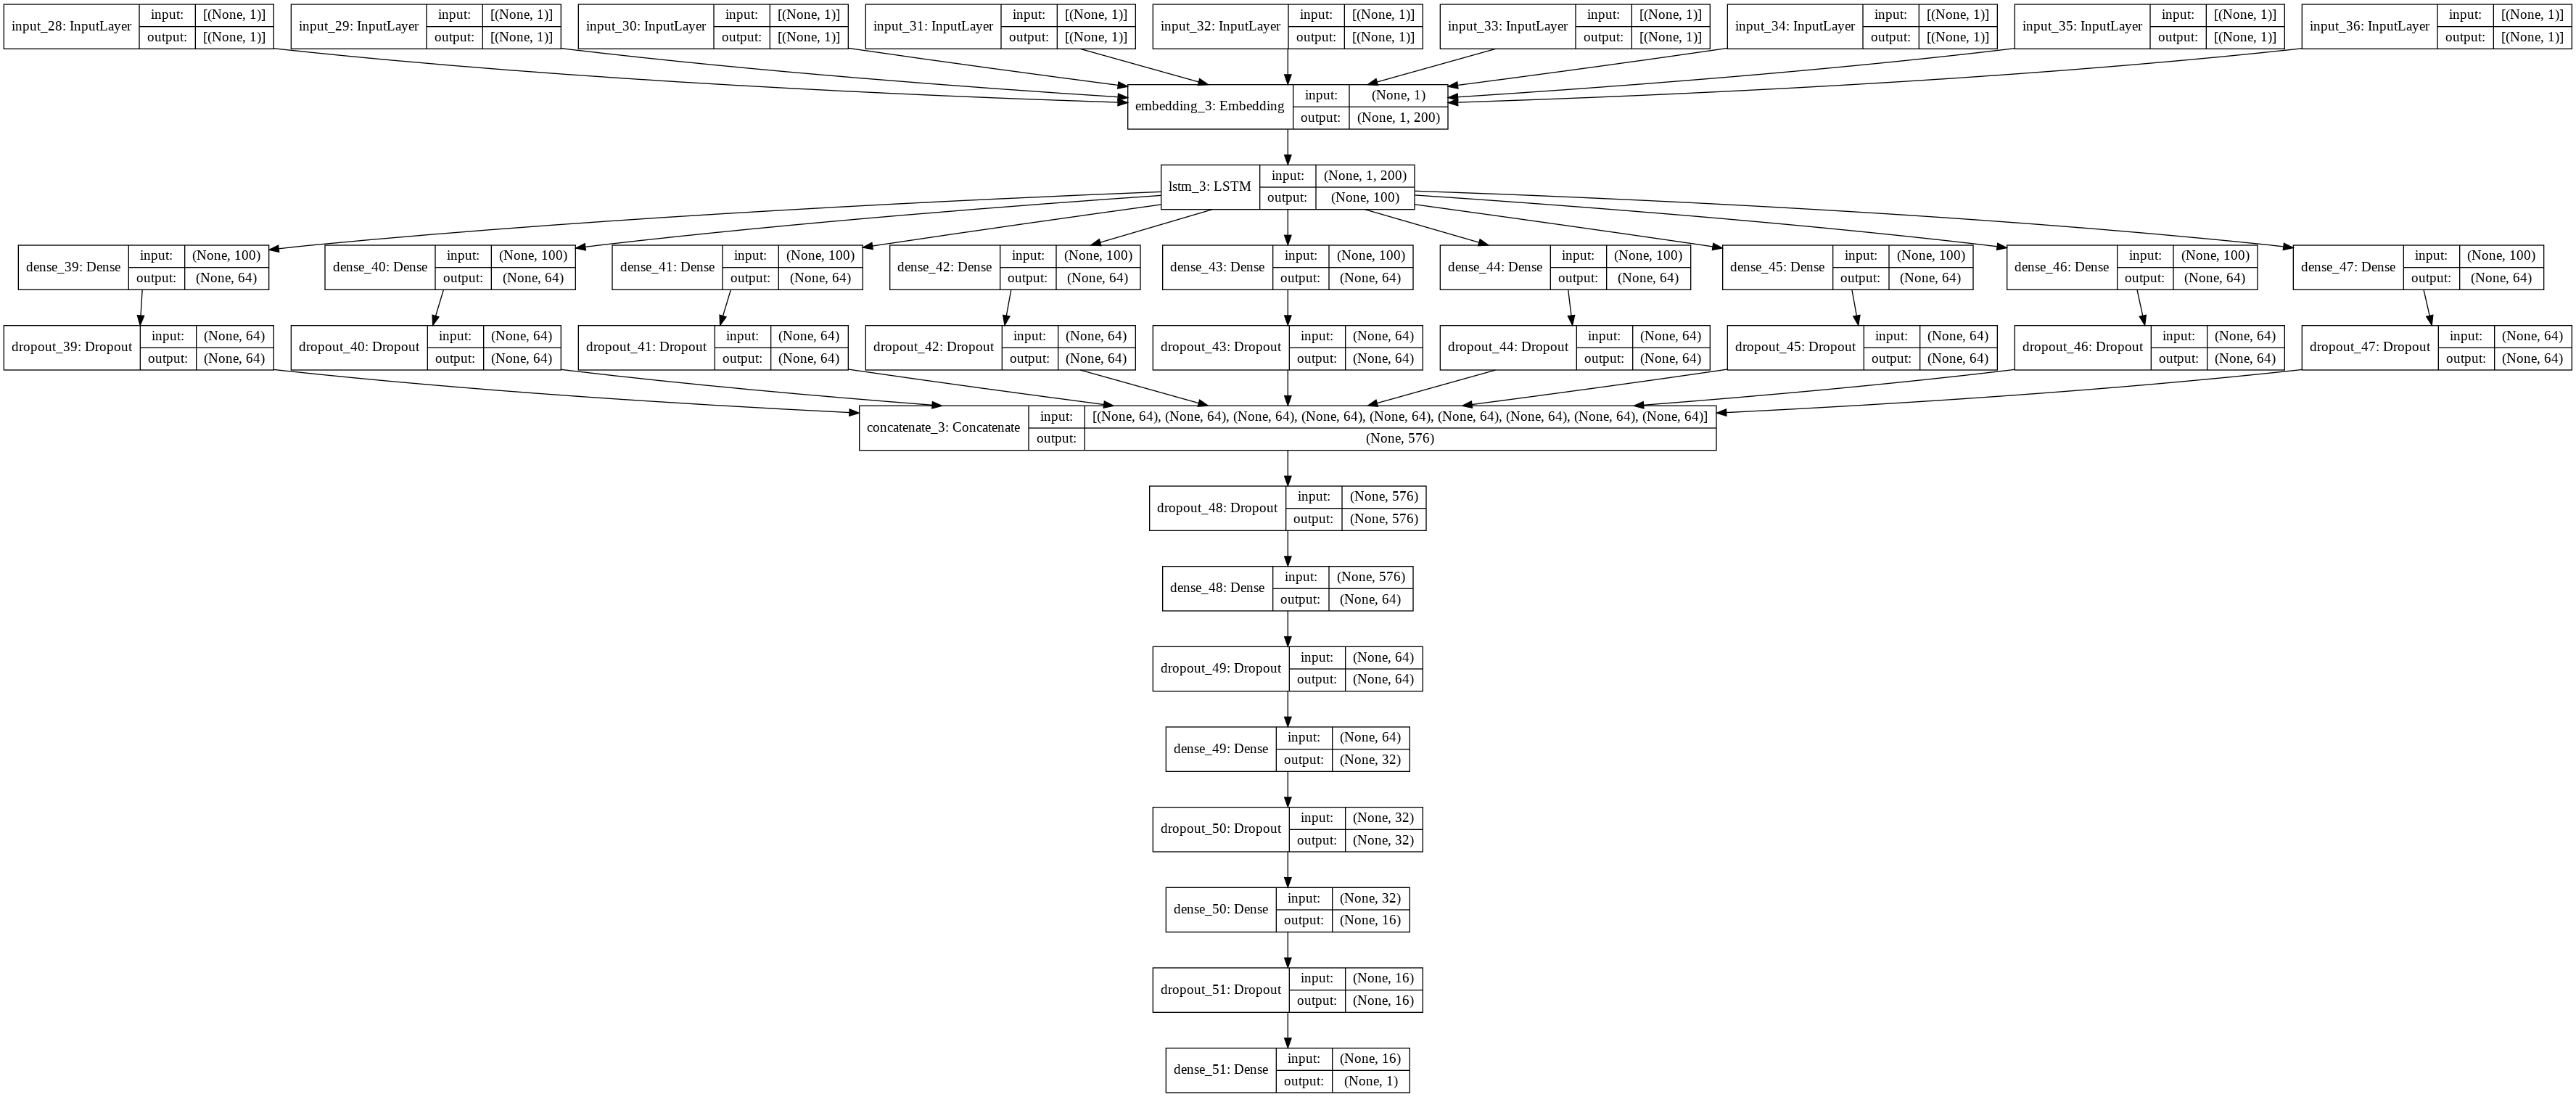

In [106]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [107]:
history = model.fit([X1, X2, X3, X4, X5, X6, X7, X8, X9], Y_train, batch_size=32, epochs=20, verbose=1)


Epoch 1/20
249/249 [==============================] - 34s 64ms/step - loss: 0.6909 - acc: 0.5647
Epoch 2/20
249/249 [==============================] - 16s 64ms/step - loss: 0.6767 - acc: 0.6701
Epoch 3/20
249/249 [==============================] - 16s 63ms/step - loss: 0.6611 - acc: 0.7039
Epoch 4/20
249/249 [==============================] - 16s 64ms/step - loss: 0.6470 - acc: 0.7159
Epoch 5/20
249/249 [==============================] - 16s 63ms/step - loss: 0.6346 - acc: 0.7339
Epoch 6/20
249/249 [==============================] - 16s 63ms/step - loss: 0.6314 - acc: 0.7272
Epoch 7/20
249/249 [==============================] - 16s 63ms/step - loss: 0.6232 - acc: 0.7332
Epoch 8/20
249/249 [==============================] - 16s 63ms/step - loss: 0.6104 - acc: 0.7432
Epoch 9/20
249/249 [==============================] - 16s 63ms/step - loss: 0.6128 - acc: 0.7420
Epoch 10/20
249/249 [==============================] - 16s 63ms/step - loss: 0.6115 - acc: 0.7346
Epoch 11/20
249/249 [========

In [108]:
X_test = test['Territory']
le = LabelEncoder()
X_test = le.fit_transform(X_test)
X_test = X_test.reshape(-1,1)
X_test.shape

(1567, 1)

In [109]:
X_test2 = test['TRF_mean']
le = LabelEncoder()
X_test2 = le.fit_transform(X_test2)
X_test2 = X_test2.reshape(-1,1)
X_test2.shape

(1567, 1)

In [110]:
X_test3 = test['Aprobacion_Especial']
le = LabelEncoder()
X_test3 = le.fit_transform(X_test3)
X_test3 = X_test3.reshape(-1,1)
X_test3.shape

(1567, 1)

In [111]:
X_test4 = test['Total_Taxable_Amount_(converted)']
le = LabelEncoder()
X_test4 = le.fit_transform(X_test4)
X_test4 = X_test4.reshape(-1,1)
X_test4.shape

(1567, 1)

In [112]:
X_test5 = test['Rango de entrega']
le = LabelEncoder()
X_test5 = le.fit_transform(X_test5)
X_test5 = X_test5.reshape(-1,1)
X_test5.shape

(1567, 1)

In [113]:
X_test6 = test['Count_products']
le = LabelEncoder()
X_test6 = le.fit_transform(X_test6)
X_test6 = X_test6.reshape(-1,1)
X_test6.shape

(1567, 1)

In [114]:
X_test7 = test['Region']
le = LabelEncoder()
X_test7 = le.fit_transform(X_test7)
X_test7 = X_test7.reshape(-1,1)
X_test7.shape

(1567, 1)

In [116]:
X_test8 = test['Opportunity_Type']
le = LabelEncoder()
X_test8 = le.fit_transform(X_test8)
X_test8 = X_test8.reshape(-1,1)
X_test8.shape

(1567, 1)

In [117]:
X_test9 = test['Account_Owner']
le = LabelEncoder()
X_test9 = le.fit_transform(X_test9)
X_test9 = X_test9.reshape(-1,1)
X_test9.shape

(1567, 1)

In [119]:
MODEL = model.predict([X_test, X_test2, X_test3, X_test4, X_test5, X_test6, X_test7, X_test8, X_test9])

sub = test[['Opportunity_ID']].copy()
sub['Target'] = MODEL
sub.to_csv("model.csv", index=False)
sub.head(50)


,Opportunity_ID,Target
0,10689,0.656964
3,10690,0.650377
8,10691,0.678792
9,10692,0.388205
15,10693,0.677376
16,10694,0.677376
17,10695,0.671522
20,10696,0.668047
24,10697,0.661494
29,10698,0.660705


In [120]:
 from google.colab import files
 files.download('model.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>